In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as pt

data = pd.read_table('classification_data_HWK2/EMGaussian.data', sep=' ', header = -1)
data = data[[0,1]].as_matrix()
data_test = pd.read_table('classification_data_HWK2/EMGaussian.test', sep=' ', header = -1)
data_test = data_test[[0,1]].as_matrix()

In [2]:
class kmeans():
    
    
    def fit(self, data, k, plot_graph = True):
        #randomly choose the k initial seeds
        seeds = 5*np.random.rand(k, data.shape[1])-2.5
        #distance array will contain the squared distance of each point with each seed
        distances = []
        for seed in seeds:
            distances.append(np.sum((data-seed)**2, axis=1))
        nearest_seed = np.argmin(distances, axis = 0)
        #assign each point to its class
        classes = []
        for label in range(k):
            classes.append(data[nearest_seed == label])
        #the new seeds are the mean position of each class
        new_seeds = []
        for i in range(len(classes)):
            if (classes[i].size > 0):
                new_seeds.append(np.mean(classes[i], axis=0))
            else:
                new_seeds.append(seeds[i])
        j =1
        #do it again until the seeds are the same
        while(np.all(np.array(seeds) - np.array(new_seeds)==0) == False):
            seeds = new_seeds
            distances = []
            for seed in seeds:
                distances.append(np.sum((data-seed)**2, axis=1))                    
            nearest_seed = np.argmin(distances, axis = 0)
            classes = []
            for label in range(k):
                classes.append(data[nearest_seed == label])
            #the new seeds are the mean position of each class
            new_seeds = []
            for i in range(len(classes)):
                if (classes[i].size > 0):
                    new_seeds.append(np.mean(classes[i], axis=0))
                else:
                    new_seeds.append(seeds[i])
        
        self.seeds = np.array(seeds)
        self.labels = nearest_seed
        self.distortion = 0
        for i in range(len(seeds)):
            self.distortion += np.sum((classes[i]-seeds[i])**2)
        #plot the figures   
        if (plot_graph):
            plt.figure(figsize = (7,5)) 
            cmap = plt.cm.get_cmap('hsv', k+1)
            for i in range(k):
                plt.scatter(classes[i][:,0], classes[i][:,1], c = cmap(i), label = i)
                plt.scatter(new_seeds[i][0], new_seeds[i][1], c = 0, marker = '+')
            plt.xlim(left = np.min(data[:,0])-0.5, right = np.max(data[:,0])+0.5)
            plt.ylim(top = np.max(data[:,1])+0.5, bottom = np.min(data[:,1])-0.5)
            plt.xlabel('x')
            plt.ylabel('y')
            plt.title('Clusters obtained by k-Means with k = %d' % k)
            plt.legend()
            plt.show()

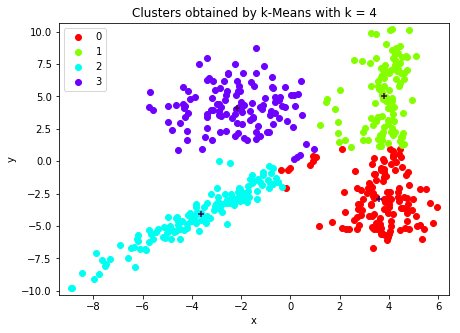

In [3]:
model = kmeans()
model.fit(data,4)

In [107]:
for i in range(10):
    model = kmeans()
    model.fit(data,4, False)
    print("Model n°%d, distortion = %f" %(i+1,model.distortion))
    print("Centers : \n", model.seeds)

Model n°1, distortion = 3240.593025
Centers : 
 [[-3.6366214  -4.05302194]
 [ 3.60401871 -2.88772669]
 [ 3.78809286  4.99905357]
 [-2.1554649   4.11299388]]
Model n°2, distortion = 3240.593025
Centers : 
 [[ 3.78809286  4.99905357]
 [-3.6366214  -4.05302194]
 [-2.1554649   4.11299388]
 [ 3.60401871 -2.88772669]]
Model n°3, distortion = 3240.173266
Centers : 
 [[-2.14180002  3.97338429]
 [ 3.78809286  4.99905357]
 [-3.72020481 -4.1849974 ]
 [ 3.57429183 -2.880828  ]]
Model n°4, distortion = 3239.240458
Centers : 
 [[ 3.47761447 -2.69706371]
 [ 3.80280826  5.10467248]
 [-3.66118948 -4.06839914]
 [-2.24472515  4.23743179]]
Model n°5, distortion = 3240.173266
Centers : 
 [[-3.72020481 -4.1849974 ]
 [ 3.78809286  4.99905357]
 [ 3.57429183 -2.880828  ]
 [-2.14180002  3.97338429]]
Model n°6, distortion = 3237.779596
Centers : 
 [[ 3.33557966 -2.644529  ]
 [-2.24034752  4.12744772]
 [-3.81879354 -4.27423441]
 [ 3.80280826  5.10467248]]
Model n°7, distortion = 3240.593025
Centers : 
 [[ 3.78809

## EM algorihtm

In [189]:
class EM():
    
    def fit_isotropic(self, data, y, seeds, plot=True):
        
        #k is the number of classes
        k = np.unique(y).shape[0]
        # n is number of data
        n = data.shape[0]
        #dimension of data
        d = data.shape[1]
        #estimate the value of the parameters for each class
        pis = np.array([np.sum(y==i)/n for i in range(k)])
        mus = seeds
        sigmas = np.array([(np.sum((data[y==i]-mus[i])**2)/n) for i in range(k)])
        stoping_condition = False
        while(stoping_condition==False):
            centered_data = np.transpose(np.array([data for i in range(k)]), (1,0,2)) - mus
            centered_data = np.transpose(centered_data, (1,0,2))
            centered_data_norm = centered_data[:,:,0]**2+centered_data[:,:,1]**2
            tau = np.multiply(pis/(2*np.pi*sigmas)**(d/2), np.exp(-1/2*centered_data_norm.T/sigmas)).T
            tau = tau / np.sum(tau, axis = 0)
            #update parameters' values
            pis = np.sum(tau, axis =1)/n
            mus = (np.sum(np.array([tau[i]*data.T for i in range(k)]), axis =2).T/np.sum(tau, axis =1)).T
            sigmas = np.sum(tau*(centered_data_norm), axis = 1)/np.sum(tau, axis = 1)/d
            
            labels = np.argmax(tau, axis = 0)
            #stoping criterion is the equality of the current labels and the previous one.
            if(np.all(labels == y)):
                stoping_condition = True
            y = labels
        #classify data
        classes = []
        for i in range(k):
            classes.append(data[labels == i])
        #compute distortion
        self.distortion = 0
        self.log_likelihood = 0.
        for i in range(k):
            self.distortion += np.sum((classes[i]-mus[i])**2)
            self.log_likelihood += np.sum([labels == i]*(np.log(pis[i])-d/2*np.log(2*np.pi*sigmas[i])-1/2/sigmas[i]*centered_data_norm[i]))
                                                         
        self.classes = classes
        self.sigmas = sigmas
        self.mus = mus
        self.pis = pis
        if(plot):
            self.plot_data('isotropic')
        self.k =k 
        
    def fit_general(self, data, y, seeds, plot=True):
        #k is the number of classes
        k = np.unique(y).shape[0]
        # n is number of data
        n = data.shape[0]
        #dimension of data
        d = data.shape[1]
        #estimate the value of the parameters for each class
        pis = np.array([np.sum(y==i)/n for i in range(k)])
        mus = seeds
        sigmas = np.zeros((k,d,d))
        for i in range(k):
            sigmas[i] = (data-mus[i]).T.dot(data-mus[i])/n
        
        stoping_condition = False
        while(stoping_condition==False):
            centered_data = np.transpose(np.array([data for i in range(k)]), (1,0,2)) - mus
            centered_data = np.transpose(centered_data, (1,0,2))
            tau = np.zeros((k,n))
            for i in range(k):
                tau[i] = pis[i]/(2*np.pi)**(d/2)/np.linalg.det(sigmas[i])**(1/2)*np.exp(-np.diag(centered_data[i].dot(np.linalg.inv(sigmas[i]).dot(centered_data[i].T)))/2 ).T
            tau = tau/np.sum(tau, axis = 0)
            
            for i in range(k):
                #update parameters' values
                pis[i] = np.sum(tau[i])/n
                mus[i] = np.sum(tau[i]*data.T, axis =1)/np.sum(tau[i])
                sigmas[i] = (tau[i]*(data-mus[i]).T).dot(data-mus[i])/np.sum(tau[i])
            labels = np.argmax(tau, axis = 0)
            #stoping criterion is the equality of the current labels and the previous one.
            if(np.all(labels == y)):
                stoping_condition = True
            y = labels
        #classify data
        classes = []
        for i in range(k):
            classes.append(data[labels == i])
        #compute distortion and log-likelihood
        self.distortion = 0   
        self.log_likelihood = 0
        for i in range(k):
            self.distortion += np.sum((classes[i]-mus[i])**2)
            self.log_likelihood += np.sum([labels == i]*(np.log(pis[i])-d/2*np.log(2*np.pi)-1/2*np.log(np.linalg.det(sigmas[i]))\
                                -np.diag(centered_data[i].dot(np.linalg.inv(sigmas[i]).dot(centered_data[i].T)))/2))
                    
        self.classes = classes
        self.sigmas = sigmas
        self.mus = mus
        self.pis = pis
        if(plot):
            self.plot_data('general')
        self.k = k
        
        
    def plot_data(self, case, classes = None):
        if (classes == None):
            classes = self.classes
        plt.figure(figsize = (7,5)) 
        sub = plt.subplot(1,1,1)
        k = len(self.classes)
        cmap = plt.cm.get_cmap('hsv', k+1)
        for i in range(k):
            #plot classification
            plt.scatter(classes[i][:,0], classes[i][:,1], c = cmap(i), label = i)
            plt.scatter(self.mus[i][0], self.mus[i][1], c = 0, marker = '+')
            #plot ellipses
            if(case == 'general'):
                v, w = np.linalg.eigh(self.sigmas[i])
                v = 2. * np.sqrt(2.) * np.sqrt(v)
                u = w[0] 
                angle = np.arctan(w[0,1] / w[0,0])
                angle = 180. * angle / np.pi
            else:
                v = [self.sigmas[i], self.sigmas[i]]
                v = 2*np.sqrt(v)*np.sqrt(2)
                angle = 0
            e = pt.Ellipse(self.mus[i], v[0], v[1], angle = angle,fill = False, edgecolor = (0,0,0))
            sub.add_artist(e)
        
        plt.xlim(left = np.min(data[:,0])-0.5, right = np.max(data[:,0])+0.5)
        plt.ylim(top = np.max(data[:,1])+0.5, bottom = np.min(data[:,1])-0.5)
        plt.xlabel('x')
        plt.ylabel('y')
        plt.title('Clusters obtained by EM algorithm, %s case' % case)
        plt.legend()
        plt.show()
        
    def predict(self, data, plot=True):
        d = data.shape[1]
        #separate case where fitting has been made for general or isotropic
        if (type(self.sigmas[0]) == np.float64):
            centered_data = np.transpose(np.array([data for i in range(self.k)]), (1,0,2)) - self.mus
            centered_data = np.transpose(centered_data, (1,0,2))
            centered_data_norm = centered_data[:,:,0]**2+centered_data[:,:,1]**2
            tau = np.multiply(self.pis/(2*np.pi*self.sigmas)**(d/2), np.exp(-1/2*centered_data_norm.T/self.sigmas)).T
            tau = tau / np.sum(tau, axis = 0)
            labels = np.argmax(tau, axis = 0)
            classes = []
            for i in range(self.k):
                classes.append(data[labels == i])
            if(plot):
                self.plot_data('isotropic', classes)
            self.distortion_pred = 0
            self.log_likelihood_pred = 0.
            for i in range(self.k):
                self.distortion_pred += np.sum((classes[i]-self.mus[i])**2)
                self.log_likelihood_pred += np.sum([labels == i]*(np.log(self.pis[i])-d/2*np.log(2*np.pi*self.sigmas[i])-1/2/self.sigmas[i]*centered_data_norm[i]))
            
            
        else:
            centered_data = np.transpose(np.array([data for i in range(self.k)]), (1,0,2)) - self.mus
            centered_data = np.transpose(centered_data, (1,0,2))
            tau = np.zeros((self.k,data.shape[0]))
            for i in range(self.k):
                tau[i] = self.pis[i]/(2*np.pi)**(d/2)/np.linalg.det(self.sigmas[i])**(1/2)*np.exp(-np.diag(centered_data[i].dot(np.linalg.inv(self.sigmas[i]).dot(centered_data[i].T)))/2 ).T
            tau = tau/np.sum(tau, axis = 0)
            labels = np.argmax(tau, axis = 0)
            classes = []
            for i in range(self.k):
                classes.append(data[labels == i])
            if(plot):
                self.plot_data('general', classes)
            self.distortion_pred = 0   
            self.log_likelihood_pred = 0
            for i in range(self.k):
                self.distortion_pred += np.sum((classes[i]-self.mus[i])**2)
                self.log_likelihood_pred += np.sum([labels == i]*(np.log(self.pis[i])-d/2*np.log(2*np.pi)-1/2*np.log(np.linalg.det(self.sigmas[i]))\
                                    -np.diag(centered_data[i].dot(np.linalg.inv(self.sigmas[i]).dot(centered_data[i].T)))/2))
        


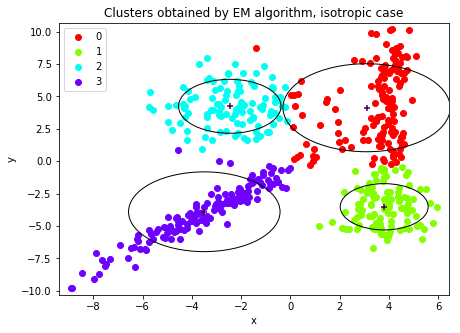

In [190]:
m = EM()
m.fit_isotropic(data, model.labels, model.seeds)

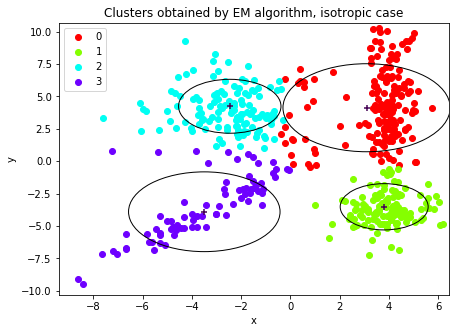

In [191]:
m.predict(data_test)

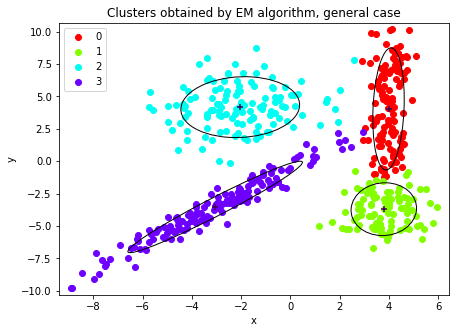

In [179]:
m1 = EM()
m1.fit_general(data, model.labels, model.seeds)

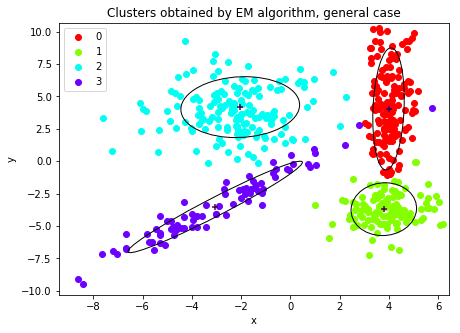

In [180]:
m1.predict(data_test)

In [192]:
m = EM()
m.fit_general(data, model.labels, model.seeds,False)
print('Training data, log-likelihood general model:', m.log_likelihood)
m.predict(data_test,False)
print('Test data, log-likelihood general model:', m.log_likelihood_pred)
m.fit_isotropic(data, model.labels, model.seeds,False)
print('Training data, log-likelihood isotropic model:', m.log_likelihood)
m.predict(data_test,False)
print('Test data, log-likelihood isotropic model:', m.log_likelihood_pred)


Training data, log-likelihood general model: -2344.718610748144
Test data, log-likelihood general model: -2425.929219664989
Training data, log-likelihood isotropic model: -2676.6791144753015
Test data, log-likelihood isotropic model: -2654.239502182047


In [193]:
m = EM()
m.fit_general(data, model.labels, model.seeds,False)
print('Training data, distortion general model:', m.distortion)
m.predict(data_test,False)
print('Test data, distortion general model:', m.distortion_pred)
m.fit_isotropic(data, model.labels, model.seeds,False)
print('Training data, distortion isotropic model:', m.distortion)
m.predict(data_test,False)
print('Test data, distortion isotropic model:', m.distortion_pred)


Training data, distortion general model: 4037.4029767138663
Test data, distortion general model: 3642.600561482935
Training data, distortion isotropic model: 3457.9281338729465
Test data, distortion isotropic model: 3354.406243240775
